In [6]:
import numpy as np
import pandas as pd
import xgboost as xgb
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from hyperopt import fmin, hp, tpe, STATUS_OK
from hyperopt.pyll.base import scope

In [12]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
non_categoricals = [f'cont{idx}' for idx in range(14)]
train_cats = pd.get_dummies(train.drop(['id', 'target'] + non_categoricals, axis=1))
test_cats = pd.get_dummies(test.drop(['id'] + non_categoricals, axis=1))
train = pd.concat([train_cats, train.loc[:, non_categoricals + ['target']]], axis=1)
test = pd.concat([test_cats, test.loc[:, non_categoricals]], axis=1)

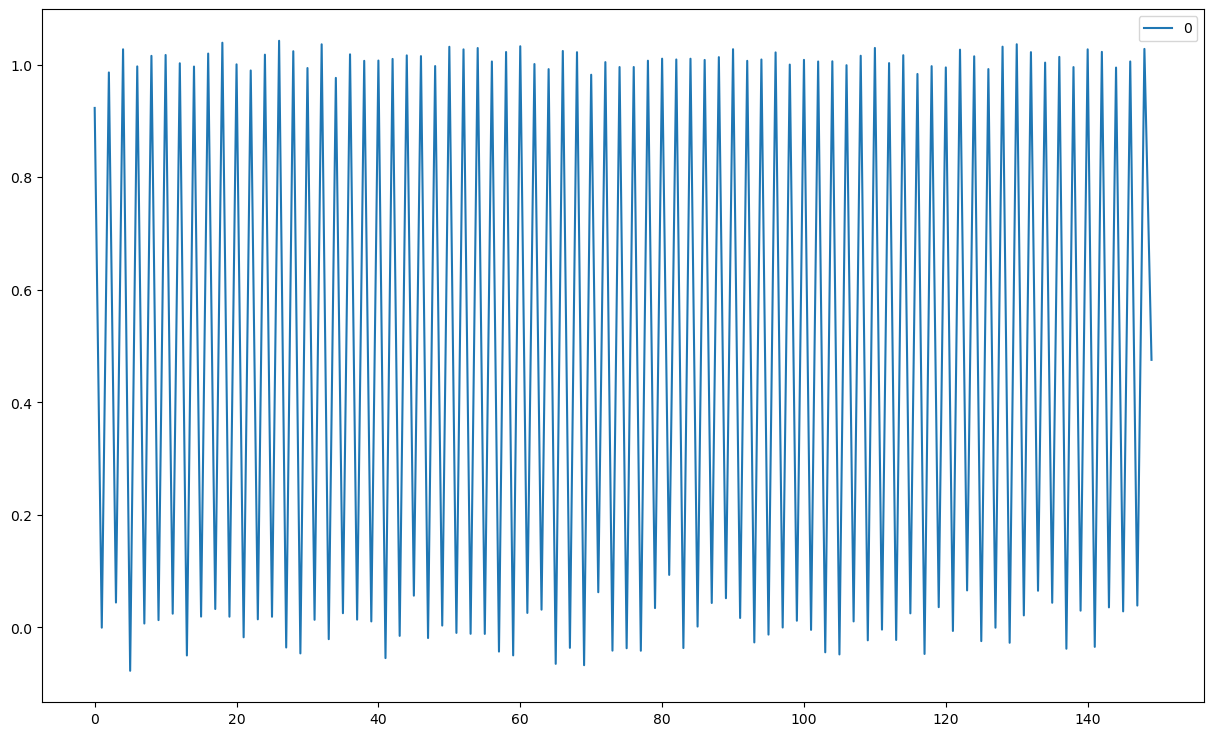

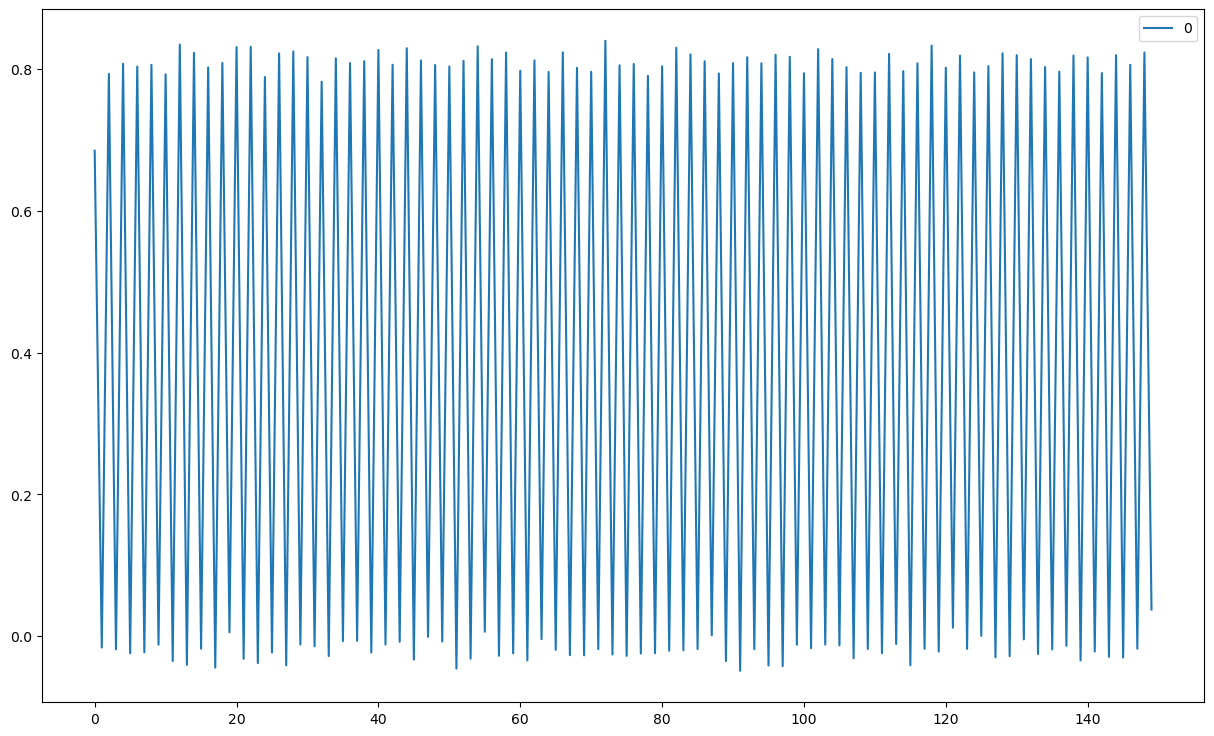

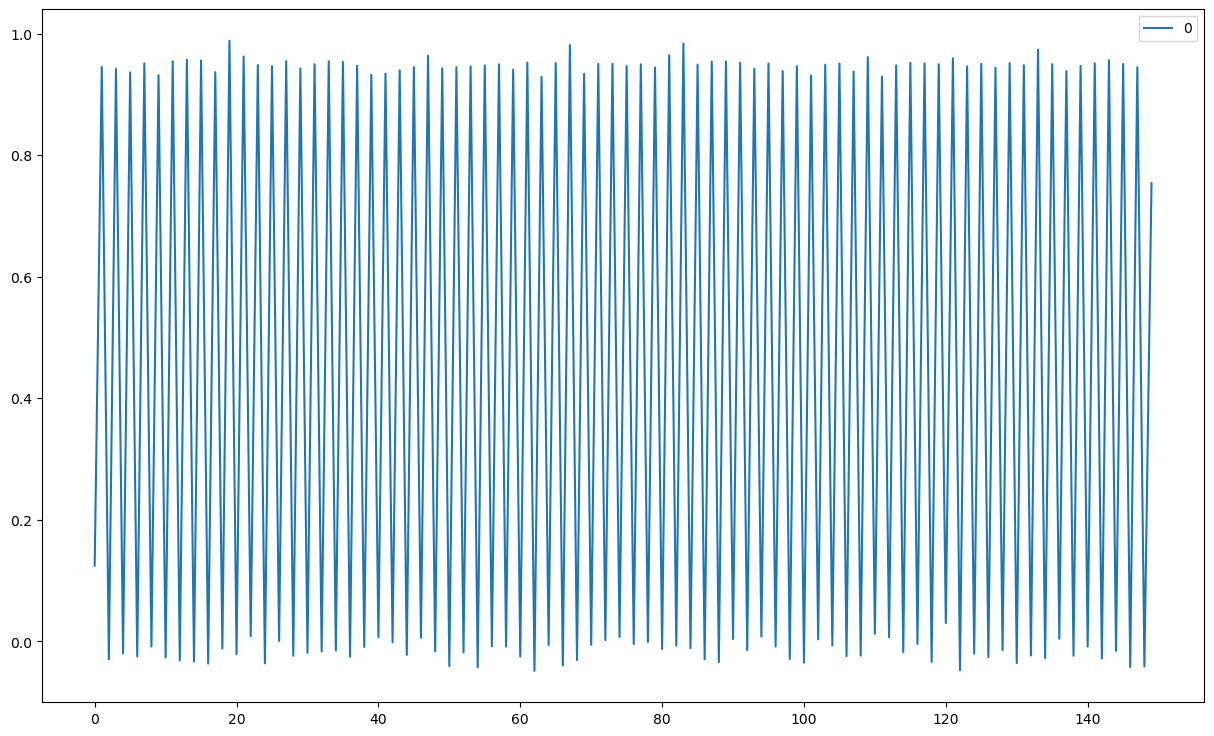

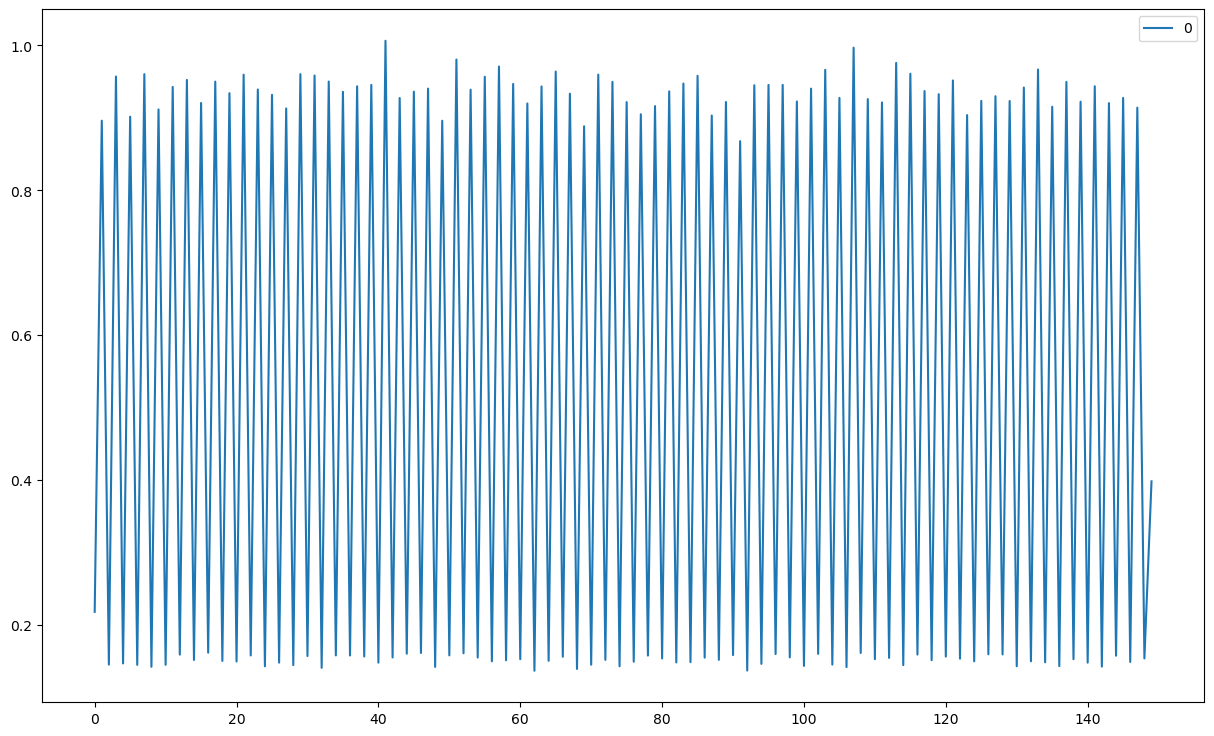

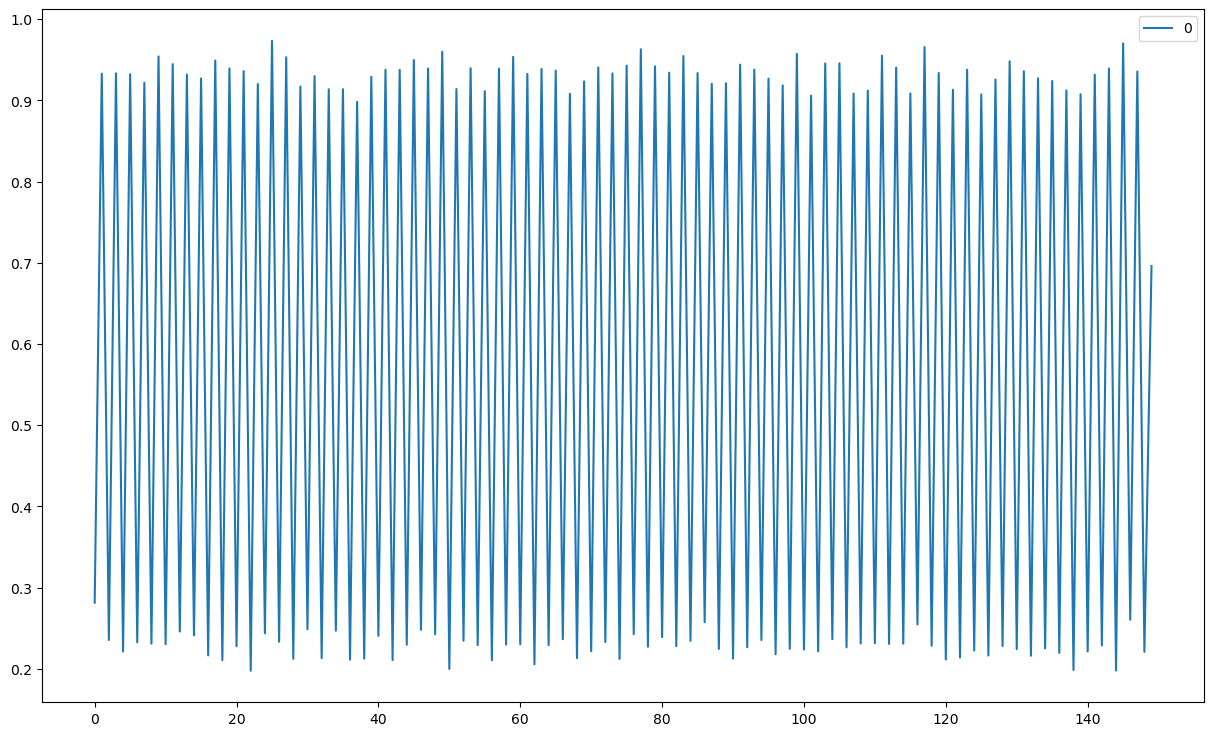

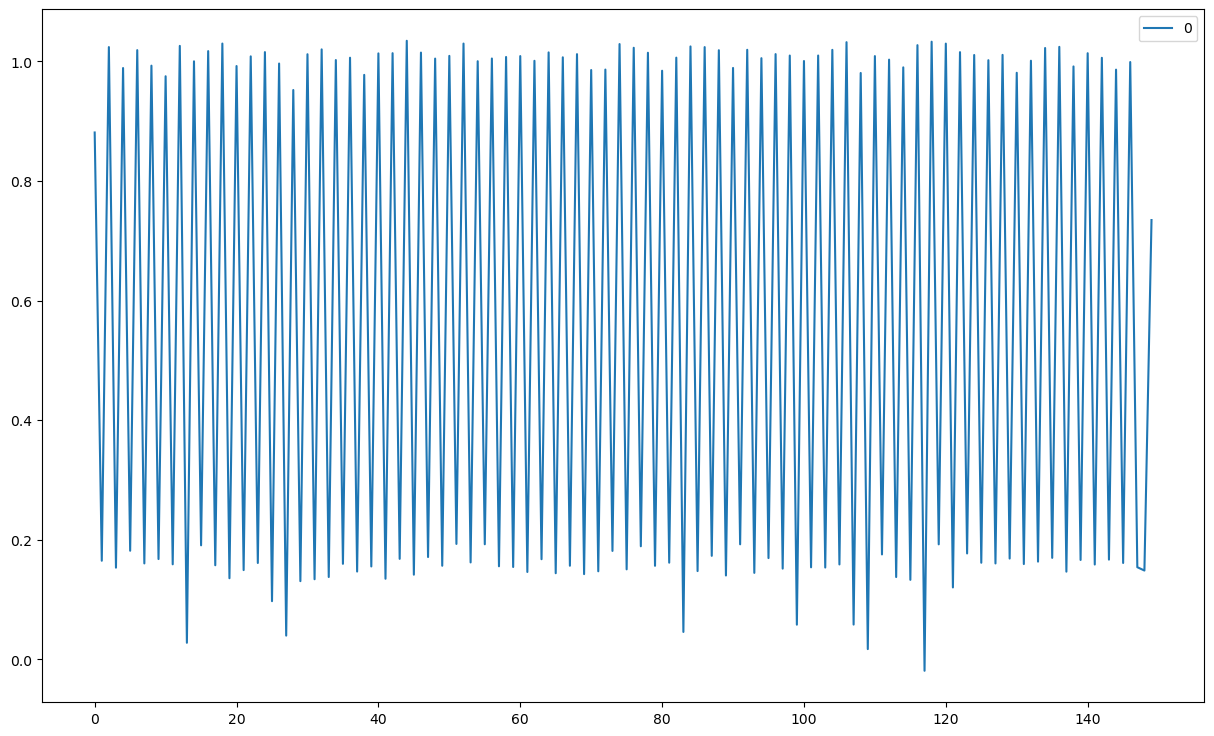

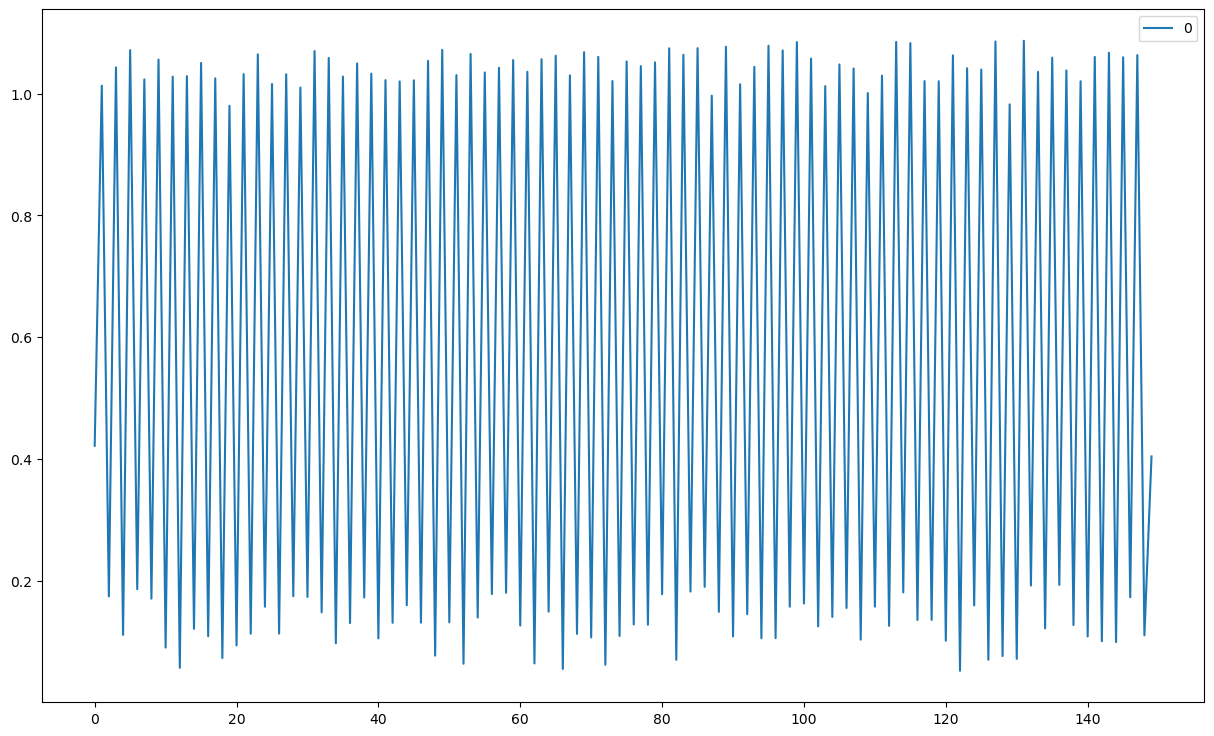

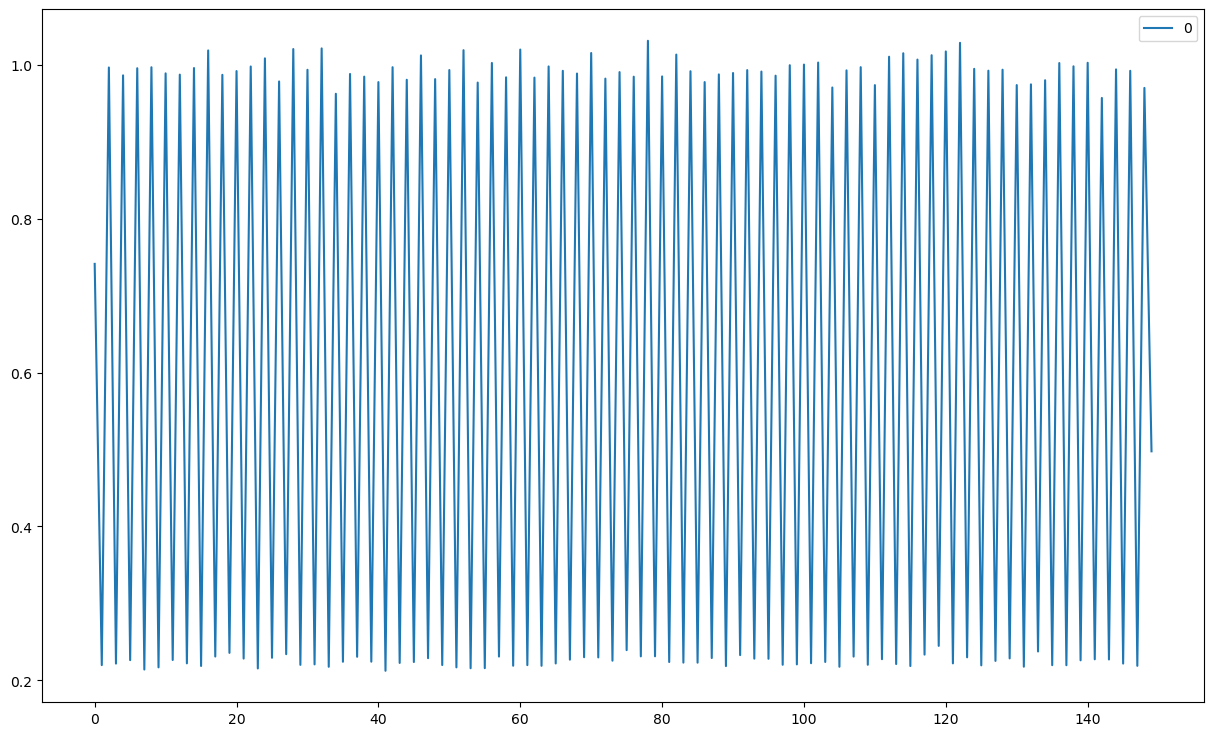

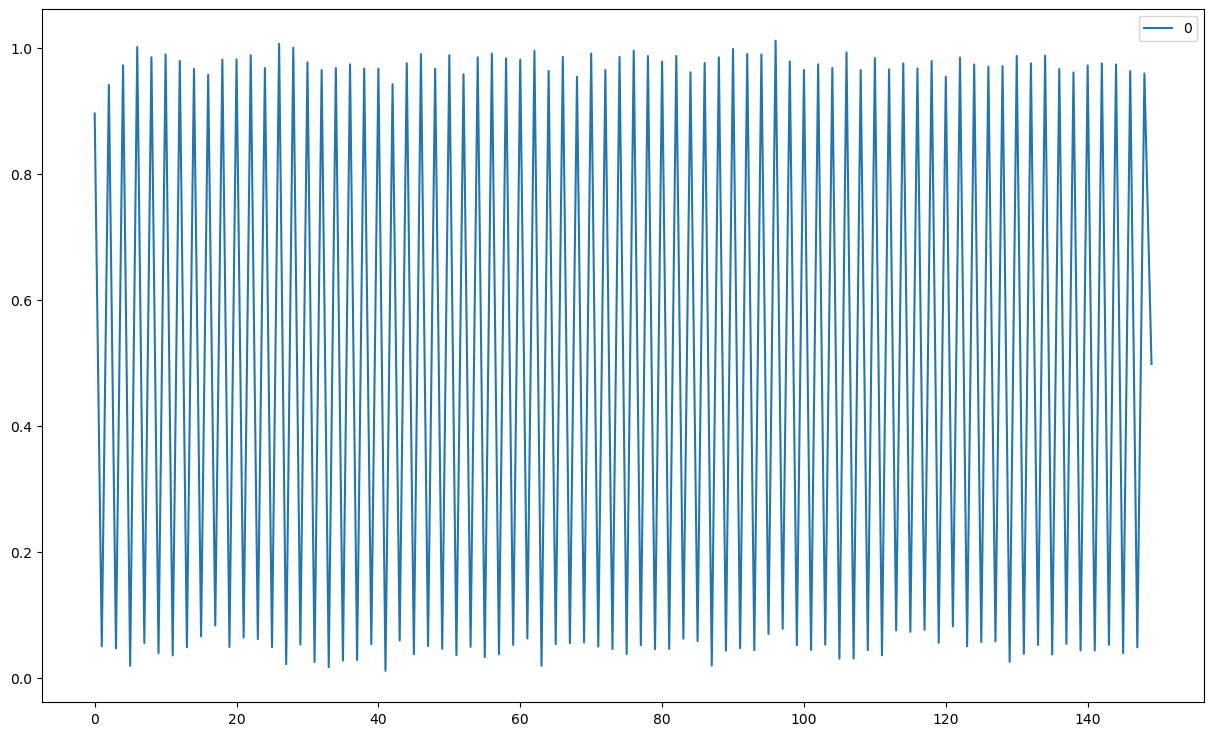

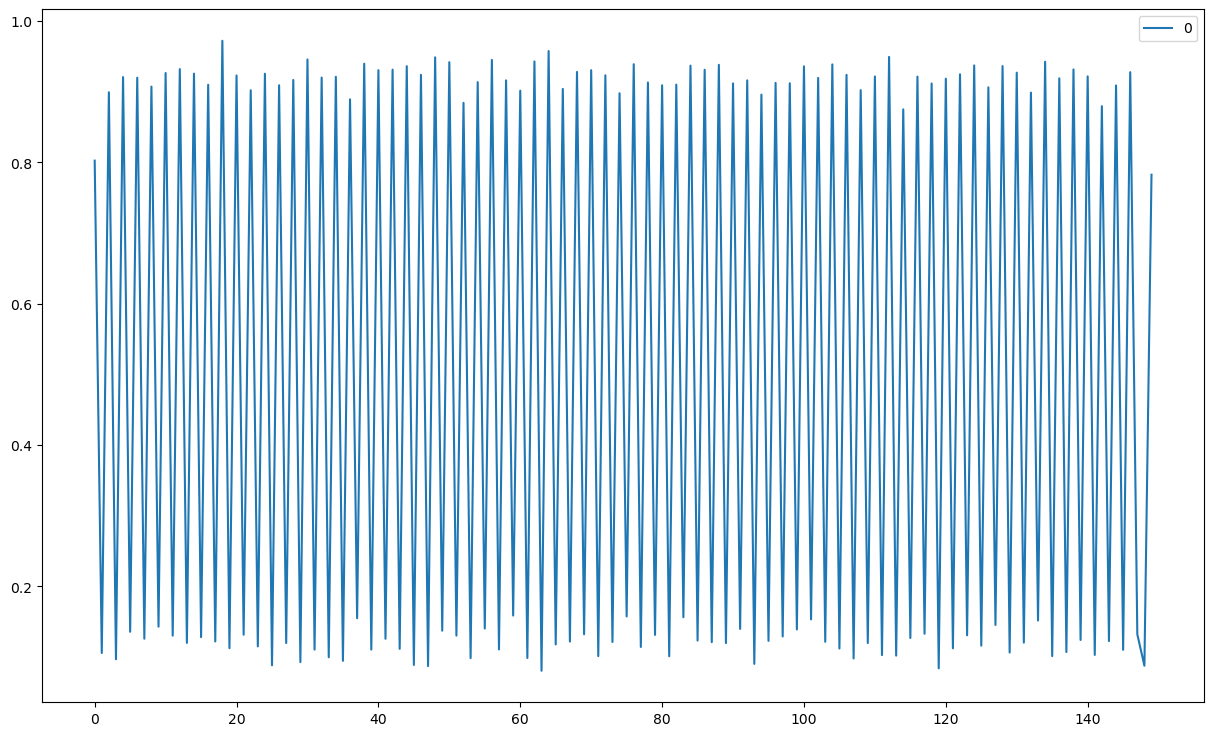

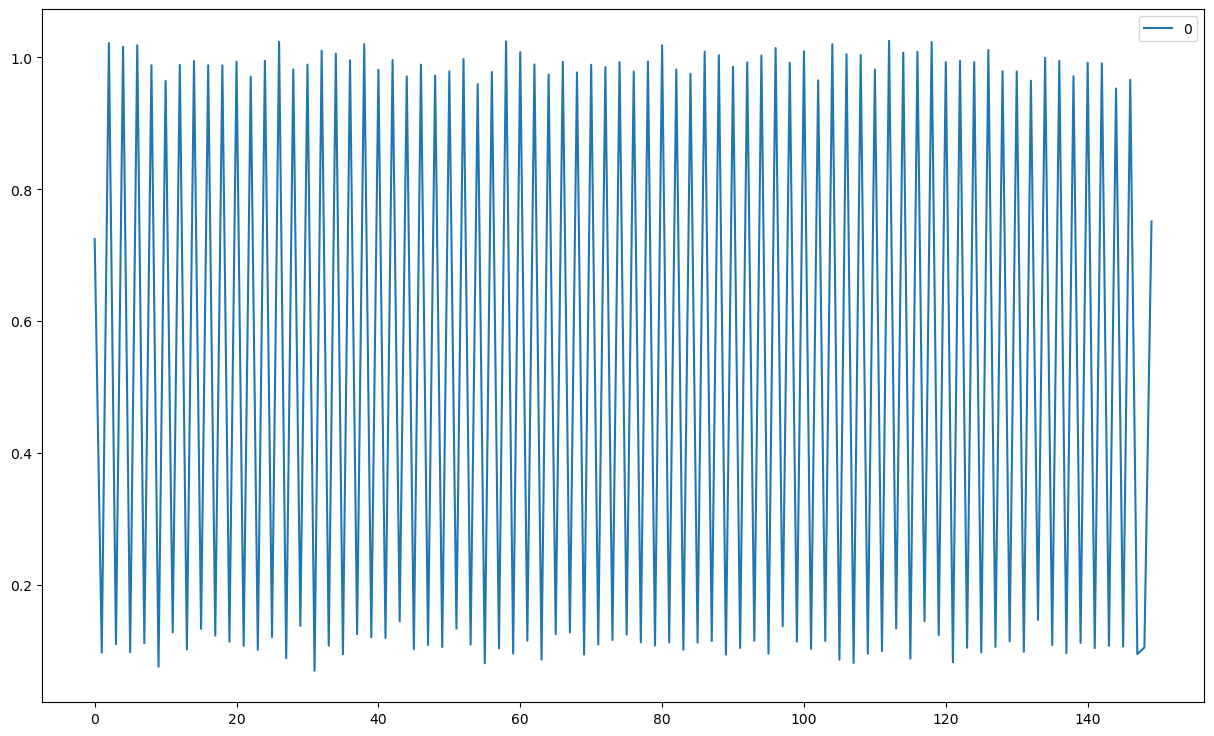

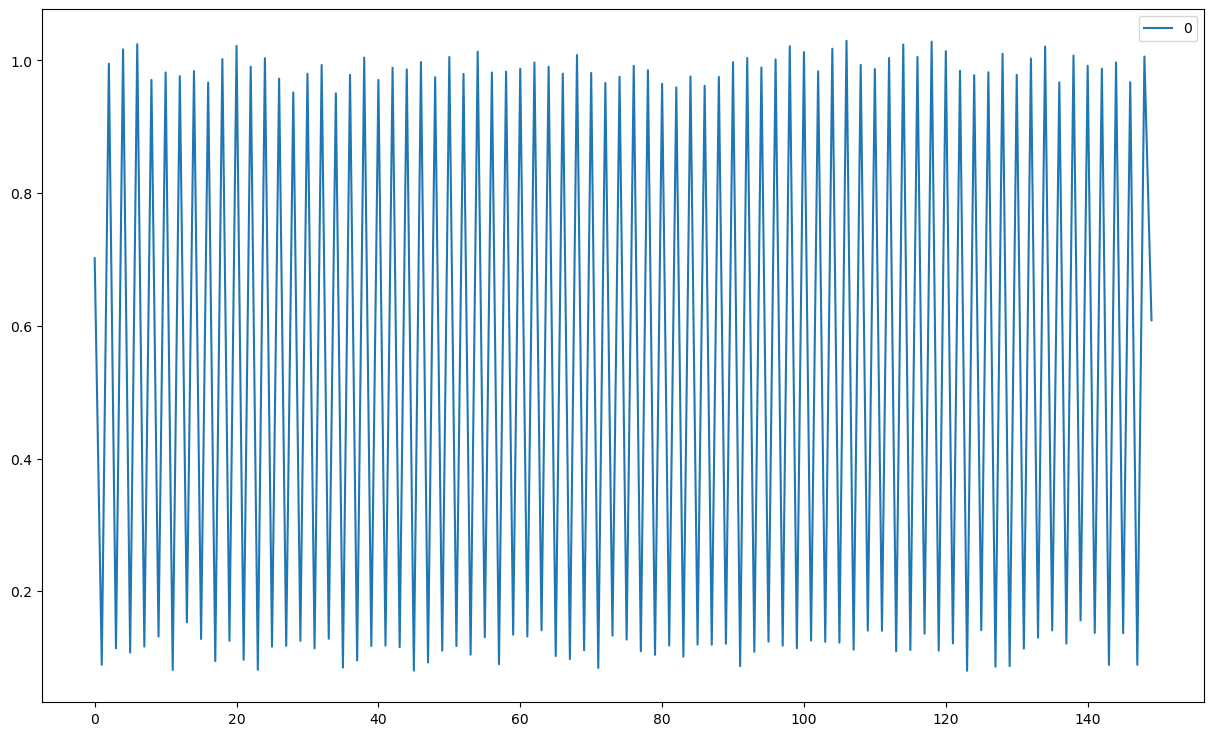

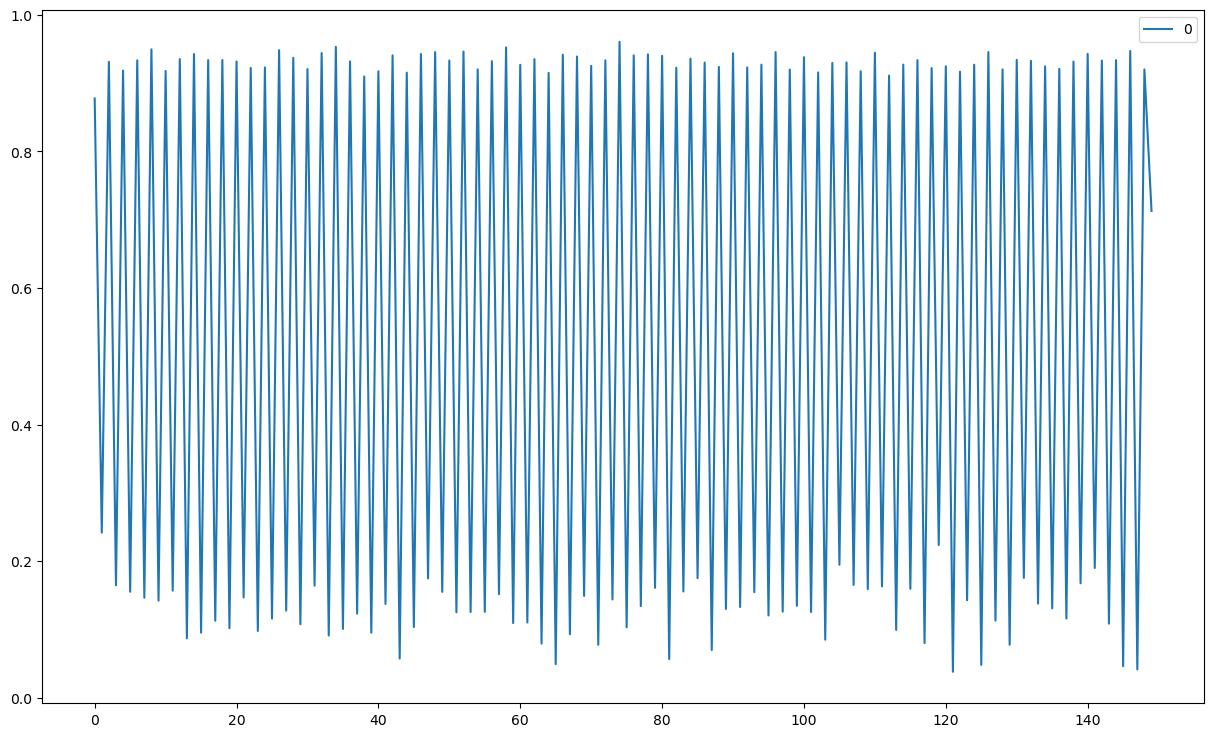

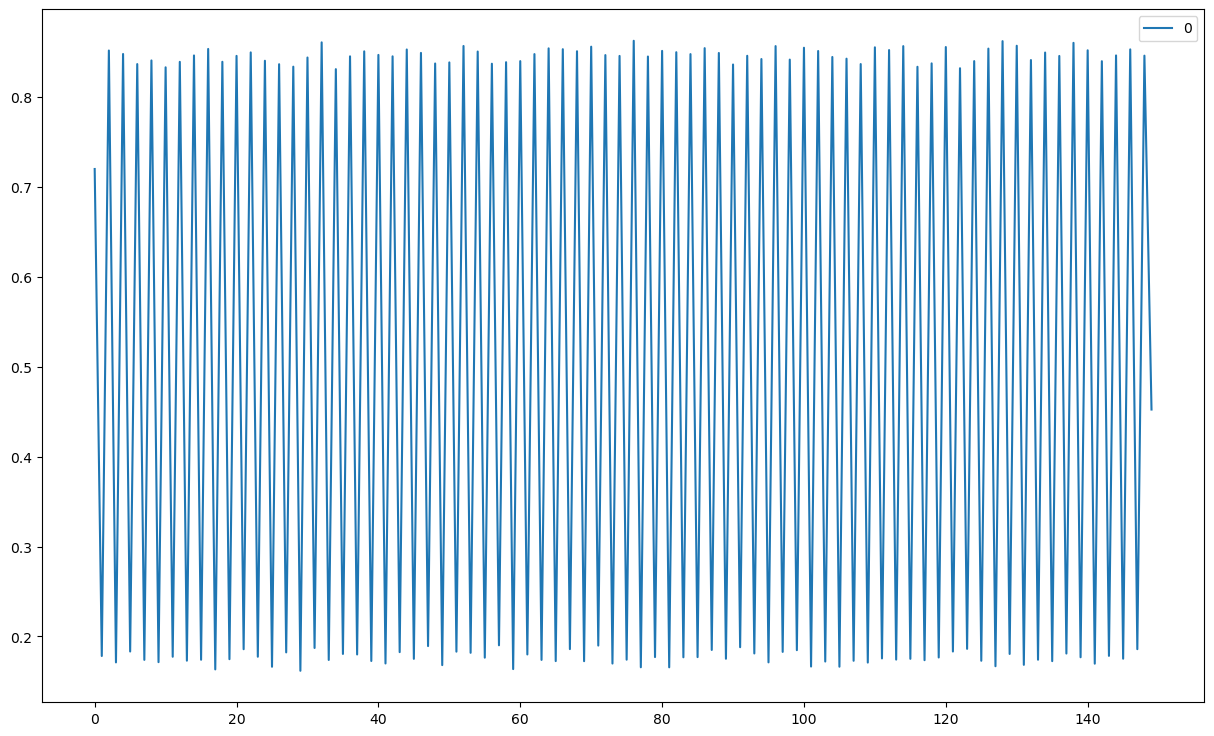

In [14]:
import lttb


plt.rcParams['figure.figsize'] = (15, 9)

for cnt in range(14):
    frame = pd.DataFrame([
        np.array(list(range(train.shape[0]))),
        train.loc[:, f'cont{cnt}'].to_numpy()
    ])
    np_array = frame.to_numpy().T
    data_downsampled = lttb.downsample(np_array, n_out=int(np_array.shape[0] * .0005))

    pd.DataFrame(data_downsampled[:, 1]).plot.line(subplots=True)
    plt.show()

In [27]:
train_np = train.to_numpy()
split = int(train_np.shape[0] * .8)
X_train = train_np[:split, :-1]
y_train = train_np[:split, -1:]
X_valid = train_np[split:, :-1]
y_valid = train_np[split:, -1:]


def find_params(
        search_space: dict,
        X_train: np.array,
        y_train: np.array,
        X_valid: np.array,
        y_valid: np.array) -> dict:
    def xgb_objective(search_space: dict) -> dict:
        regressor = xgb.XGBRegressor(**search_space)

        regressor.fit(X_train, y_train)

        y_pred = regressor.predict(X_valid)
        accuracy = mean_squared_error(y_valid, y_pred)

        return {'loss': accuracy, 'status': STATUS_OK}

    algorithm = tpe.suggest
    best_params = fmin(
        fn=xgb_objective,
        space=search_space,
        algo=algorithm,
        max_evals=100)

    return best_params

In [30]:
xgb_params_all = find_params({
    'max_depth': scope.int(hp.quniform('max_depth', 1, 15, 1)),
    'gamma': hp.uniform ('gamma', 0, 1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
    'min_child_weight' : hp.uniform('min_child_weight', 0, 10),
    'learning_rate': hp.uniform('learning_rate', 0, .15),
    'random_state': 5,
    'max_bin' : scope.int(hp.quniform('max_bin', 200, 750, 1))}, X_train, y_train, X_valid, y_valid)

100%|██████████| 100/100 [28:50<00:00, 17.31s/trial, best loss: 0.7137203214658348]


Loss is just awful, but maybe it can do some proper predictions basing only on the continuous variables?

In [31]:
xgb_params_conts = find_params({
    'max_depth': scope.int(hp.quniform('max_depth', 1, 15, 1)),
    'gamma': hp.uniform ('gamma', 0, 1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
    'min_child_weight' : hp.uniform('min_child_weight', 0, 10),
    'learning_rate': hp.uniform('learning_rate', 0, .15),
    'random_state': 5,
    'max_bin' : scope.int(hp.quniform('max_bin', 200, 750, 1))}, X_train[:, 56:-1], y_train, X_valid[:, 56:-1], y_valid)

100%|██████████| 100/100 [20:28<00:00, 12.29s/trial, best loss: 0.7449867937782743]


Still awful, maybe only continuous cols then?

In [32]:
xgb_params_cats = find_params({
    'max_depth': scope.int(hp.quniform('max_depth', 1, 15, 1)),
    'gamma': hp.uniform ('gamma', 0, 1),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0, 1),
    'min_child_weight' : hp.uniform('min_child_weight', 0, 10),
    'learning_rate': hp.uniform('learning_rate', 0, .15),
    'random_state': 5,
    'max_bin' : scope.int(hp.quniform('max_bin', 200, 750, 1))}, X_train[:, :56], y_train, X_valid[:, :56], y_valid)

100%|██████████| 100/100 [09:28<00:00,  5.68s/trial, best loss: 0.7523391647783986]
